# 特征工程 Feature Engineering

前面我们学习了在机器学习中数据的表示：特征矩阵X ``[n_samples, n_features]``和标签向量。

然而现实中，数据不一定是这个形式的，因此有时需要人为设计。

本节将处理如下类型的数据

- 类别/分类数据;


- 文本数据;


- 图像数据。

In [2]:
import sklearn

sklearn.__version__

'0.23.2'

## 一、类别特征

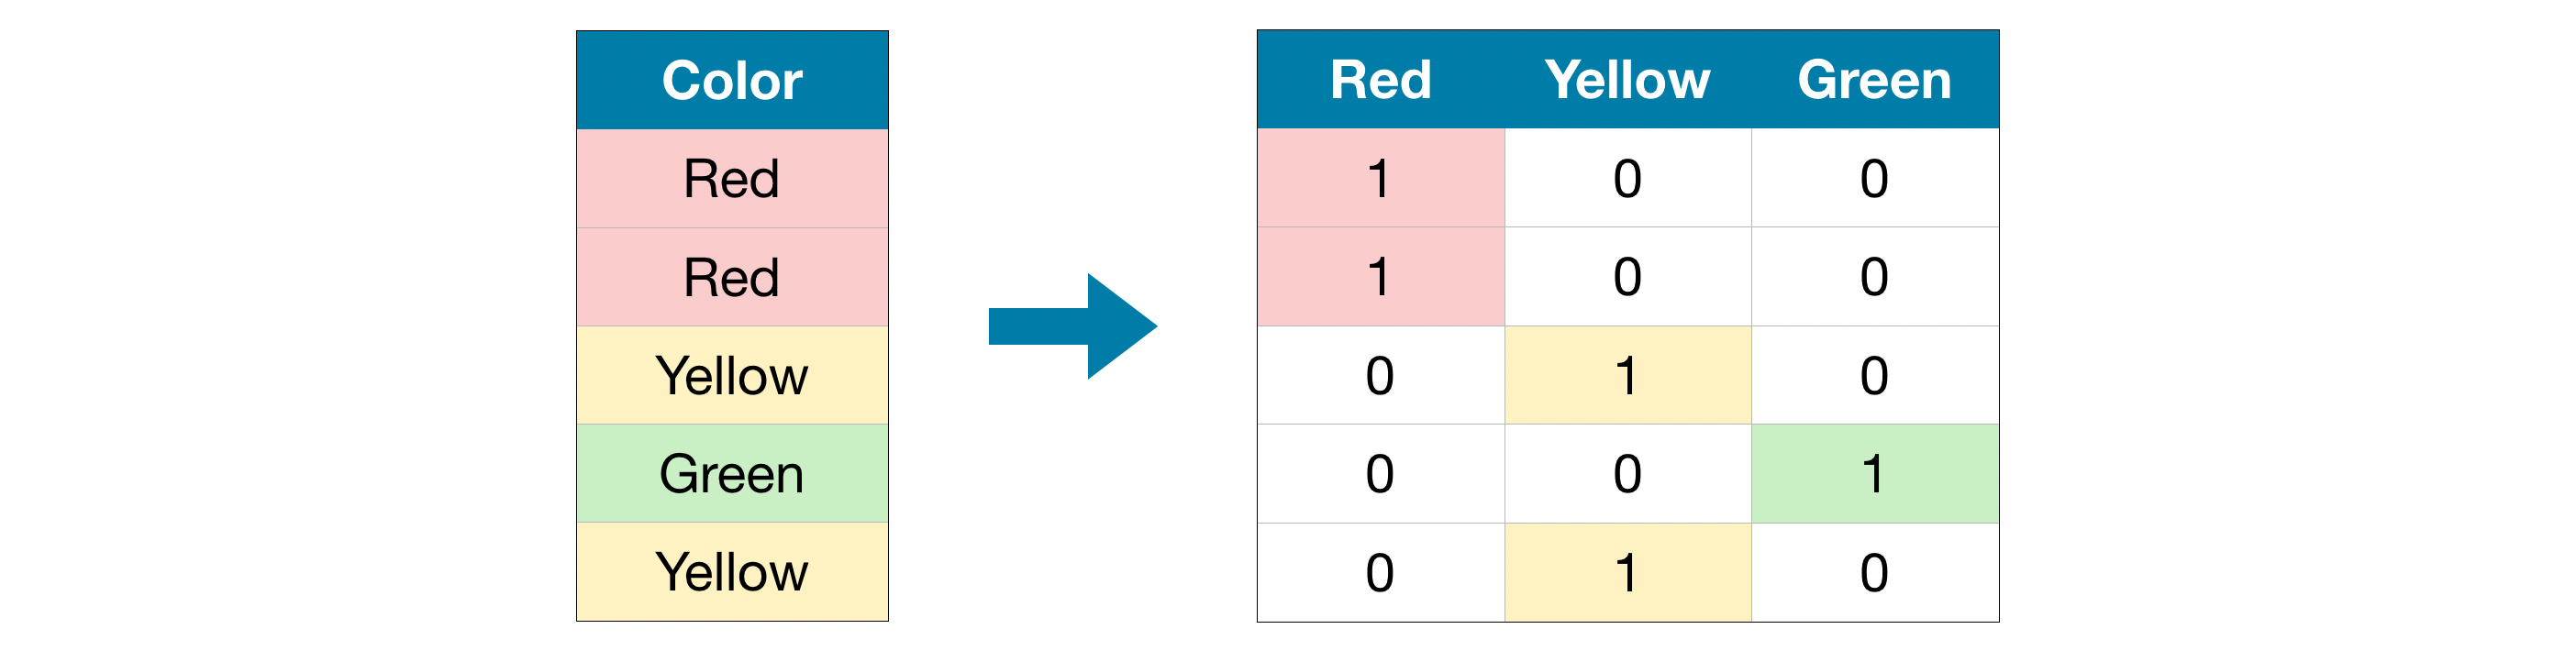

一类非数值型的数据：类别数据。

比如房子信息：

In [3]:
data = [
    {'price': 850000, 'rooms': 4, 'neighborhood': 'Queen Anne'},
    {'price': 700000, 'rooms': 3, 'neighborhood': 'Fremont'},
    {'price': 650000, 'rooms': 3, 'neighborhood': 'Wallingford'},
    {'price': 600000, 'rooms': 2, 'neighborhood': 'Fremont'}
]

一种做法就是如下数字化类别:

In [4]:
{'Queen Anne': 1, 'Fremont': 2, 'Wallingford': 3};

这种做法并不合理，因为这样会暗示着一定的关系，如 *Queen Anne < Fremont < Wallingford*, 甚至 *Wallingford - Queen Anne = Fremont*, 而这样的关系并没有实际意义。

因此要将它们独立开，不需要相互间的大小关系。一般采用独热编码 *one-hot encoding*。

在 Scikit-Learn 中，可以用 ``DictVectorizer``：

In [5]:
data

[{'price': 850000, 'rooms': 4, 'neighborhood': 'Queen Anne'},
 {'price': 700000, 'rooms': 3, 'neighborhood': 'Fremont'},
 {'price': 650000, 'rooms': 3, 'neighborhood': 'Wallingford'},
 {'price': 600000, 'rooms': 2, 'neighborhood': 'Fremont'}]

In [6]:
from sklearn.feature_extraction import DictVectorizer

vec = DictVectorizer(sparse=False, dtype=int)
vec.fit_transform(data)

array([[     0,      1,      0, 850000,      4],
       [     1,      0,      0, 700000,      3],
       [     0,      0,      1, 650000,      3],
       [     1,      0,      0, 600000,      2]])

向量表示一个类别，例如用 [1, 0, 0] 表示 'Fremont'。

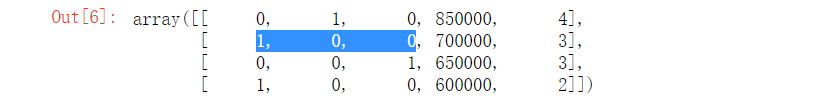

通过这种方式，为分类数据建立了类别特征，之后就可以传给 Scikit-Learn 模型进一步学习。

可以调用如下方法查看各特征名字:

In [7]:
vec.get_feature_names()

['neighborhood=Fremont',
 'neighborhood=Queen Anne',
 'neighborhood=Wallingford',
 'price',
 'rooms']

当类别比较多时，这样做会显著增加数据大小。但是可以设置 `sparse=True` 来开启稀疏编码:

In [8]:
vec = DictVectorizer(sparse=True, dtype=int)
vec.fit_transform(data)

<4x5 sparse matrix of type '<class 'numpy.int32'>'
	with 12 stored elements in Compressed Sparse Row format>

另外，还可以选择 `sklearn.preprocessing.OneHotEncoder` 和 `sklearn.feature_extraction.FeatureHasher` 等作类似编码。

## 二、文本特征

用数字表示文本，简单的做法就是**统计词的频率**。

In [11]:
# 看成文档，共三句话
sample = ['problem of evil',
          'evil queen',
          'horizon problem']

条用 Scikit-Learn 的 `CountVectorizer` 统计词频：

In [47]:
from sklearn.feature_extraction.text import CountVectorizer

vec = CountVectorizer()
X = vec.fit_transform(sample)
X

<3x5 sparse matrix of type '<class 'numpy.int64'>'
	with 7 stored elements in Compressed Sparse Row format>

In [48]:
# sample 里总共 5 个单词
X.toarray()

array([[1, 0, 1, 1, 0],
       [1, 0, 0, 0, 1],
       [0, 1, 0, 1, 0]], dtype=int64)

将其转化为 `DataFrame`：

In [49]:
import pandas as pd

pd_x = pd.DataFrame(X.toarray(), columns=vec.get_feature_names())

In [50]:
pd_x

,evil,horizon,of,problem,queen
0,1,0,1,1,0
1,1,0,0,0,1
2,0,1,0,1,0


每个单词看成一个特征，一句话里有某个单词，对应特征值为 1，否则为 0。

但是这样会引起一个问题：某文档里如果单词很多，会造成文档间的不平衡。因此对每行进行单位化处理，即 **term frequency-inverse document frequency**（**TF–IDF**）：

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer

vec = TfidfVectorizer()

X = vec.fit_transform(sample)
pd_x = pd.DataFrame(X.toarray(), columns=vec.get_feature_names())

In [16]:
pd_x

,evil,horizon,of,problem,queen
0,0.517856,0.000000,0.680919,0.517856,0.000000
1,0.605349,0.000000,0.000000,0.000000,0.795961
2,0.000000,0.795961,0.000000,0.605349,0.000000


## 三、图像特征

- 对于图像来说，建立特征比较复杂。


- 可以直接用像素值，提取边缘，也可以转化为频率，梯度分布等等。


- 但目前来说，在数据量允许的情况下，用神经网络自动提取特征往往表现更好。

## 四、派生/导出特征 Derived Features

- 从一维数据构建多项式特征 `polynomial features`。


- 这样做可以将一个线性回归模型当成多项式回归模型使用。


- 数学上称作基函数回归 `basis function regression`。

In [41]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')

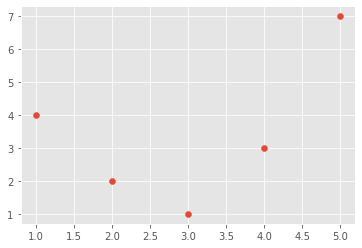

In [42]:
x = np.array([1, 2, 3, 4, 5])
y = np.array([4, 2, 1, 3, 7])
plt.scatter(x, y);

如果用线性回归模型 `LinearRegression` 去拟合:

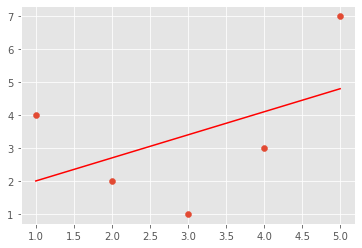

In [43]:
from sklearn.linear_model import LinearRegression

X = x[:, np.newaxis]
model = LinearRegression().fit(X, y)
yfit = model.predict(X)
plt.scatter(x, y)
plt.plot(x, yfit, c='r');

- 这个例子说明，$x$ 和 $y$ 并不是线性关系，需要用更复杂的模型去拟合。


- 可以曾加 $x$ 的多项式，如 $x^2, x^3, ...\;$。


- 相当于构建这样的函数： $y = f(x, x^2, x^3, ... )\;$。

增加多项式特征:

In [44]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=3, include_bias=False)

X2 = poly.fit_transform(X)

X2

array([[  1.,   1.,   1.],
       [  2.,   4.,   8.],
       [  3.,   9.,  27.],
       [  4.,  16.,  64.],
       [  5.,  25., 125.]])

派生特征矩阵中第一列是 $x$, 第二列是 $x^2$, 第三列则是 $x^3$。

再次用线性回归模型拟合:

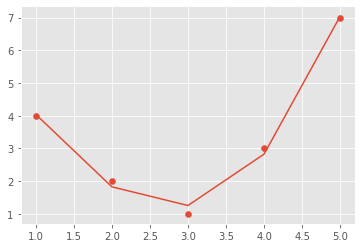

In [45]:
model = LinearRegression().fit(X2, y)
yfit = model.predict(X2)
plt.scatter(x, y)
plt.plot(x, yfit);

上面这种方法没有更改模型，只是变换了输入数据。

## 五、填补缺失数据

In [22]:
from numpy import nan

X = np.array([[ nan, 0,   3  ],
              [ 3,   7,   9  ],
              [ 3,   5,   2  ],
              [ 4,   nan, 6  ],
              [ 8,   8,   1  ]])
y = np.array([14, 16, -1,  8, -5])

比如使用列中已有数据的平均值填充缺失数据:

In [26]:
from sklearn.impute import SimpleImputer as SI

simp = SI(missing_values=np.nan, strategy='mean')

X2 = simp.fit_transform(X)
X2

array([[4.5, 0. , 3. ],
       [3. , 7. , 9. ],
       [3. , 5. , 2. ],
       [4. , 5. , 6. ],
       [8. , 8. , 1. ]])

In [25]:
model = LinearRegression().fit(X2, y)
model.predict(X2)

array([13.14869292, 14.3784627 , -1.15539732, 10.96606197, -5.33782027])

## 六、特征管线 Feature Pipelines

可以将上文中的各个步骤连起来，组成管线。比如：

1. 补缺失数据


2. 扩充到 $2$ 次特征


3. 拟合线性回归

In [38]:
from sklearn.pipeline import make_pipeline

model = make_pipeline(SI(strategy='mean'),
                      PolynomialFeatures(degree=2),
                      LinearRegression())

管线封装成标准的 Scikit-Learn 对象，使用起来还是一样：

In [39]:
# X 带缺失值

X

array([[nan,  0.,  3.],
       [ 3.,  7.,  9.],
       [ 3.,  5.,  2.],
       [ 4., nan,  6.],
       [ 8.,  8.,  1.]])

In [40]:
model.fit(X, y)  

print(y)

model.predict(X)

[14 16 -1  8 -5]


array([14., 16., -1.,  8., -5.])